In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gb-credit-default/sample_submission.csv
/kaggle/input/gb-credit-default/train.csv
/kaggle/input/gb-credit-default/test.csv


In [2]:
TRAIN_DATASET_PATH = '../input/gb-credit-default/train.csv'
TEST_DATASET_PATH = '../input/gb-credit-default/test.csv'
SUBMIT_DATASET_PATH = '../input/gb-credit-default/sample_submission.csv'

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
submit = pd.read_csv(SUBMIT_DATASET_PATH)
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

**EDA**

<AxesSubplot:xlabel='Credit Default', ylabel='count'>

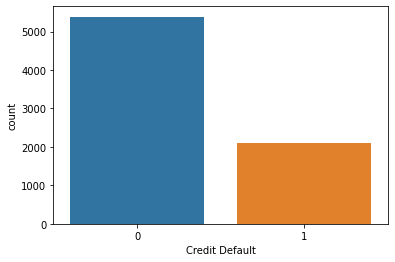

In [3]:
import seaborn as sns
sns.countplot(x='Credit Default', data=df_train)

Testing zero hypotesis

In [4]:
submit['Credit Default'] = 0
submit.to_csv('hypotesis_testing.csv', index=False)

In [5]:
submit = submit.drop(columns='Credit Default')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
target_name = 'Credit Default'
num_feature_names = [col for col in df_train.drop(target_name, axis=1).columns \
                     if df_train.dtypes[col] != np.object]
cat_feature_names = [col for col in df_train.drop(target_name, axis=1).columns \
                     if col not in num_feature_names]
selected_features = cat_feature_names + num_feature_names

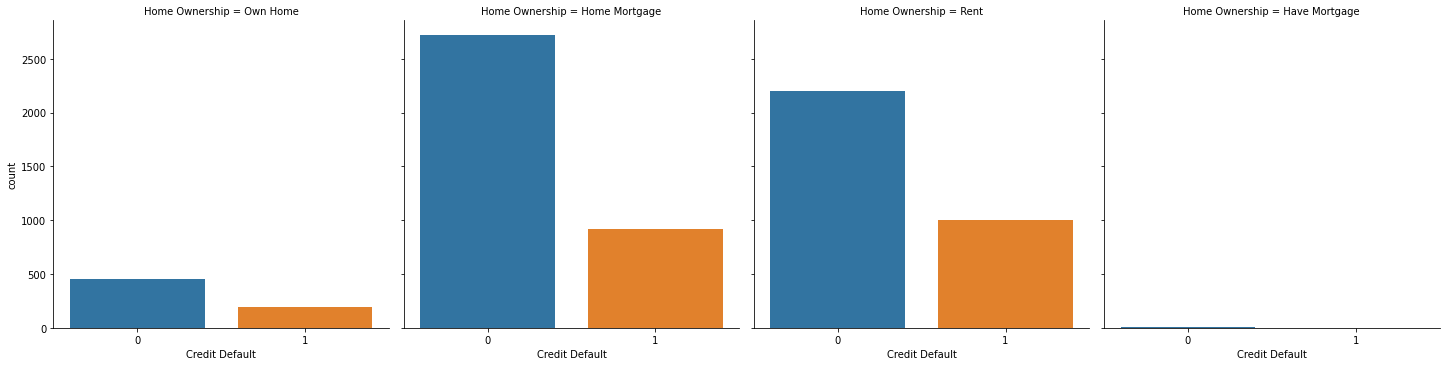

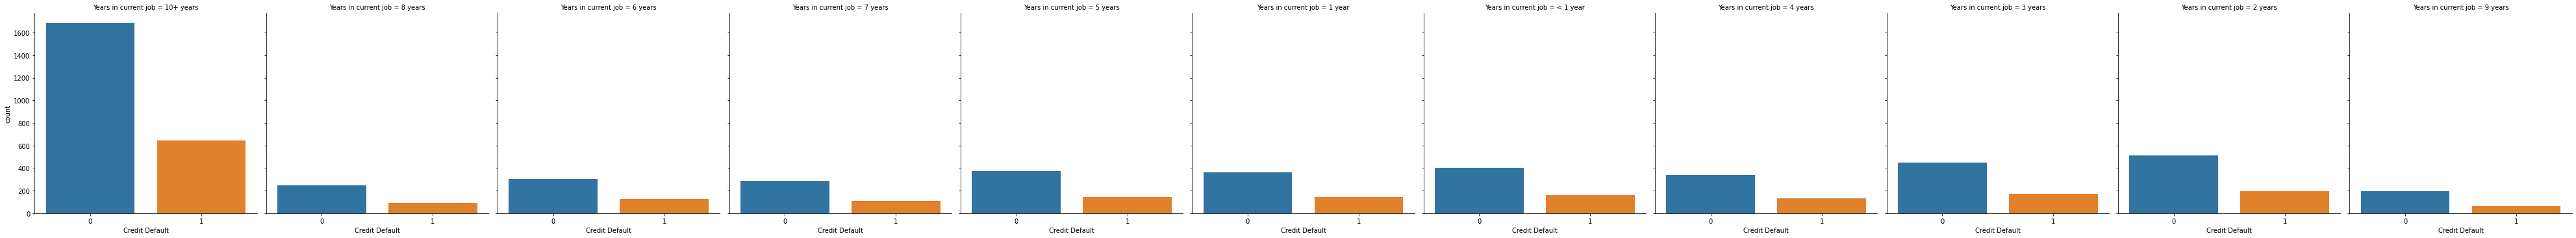

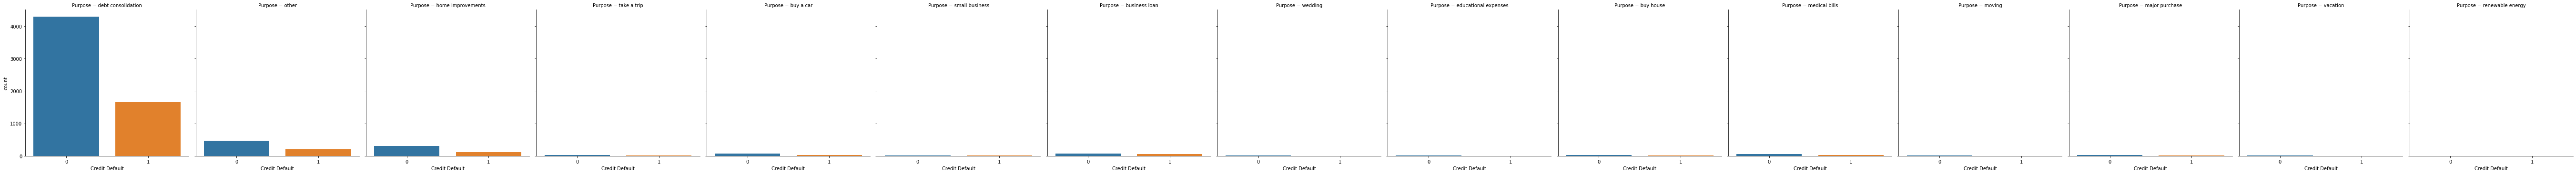

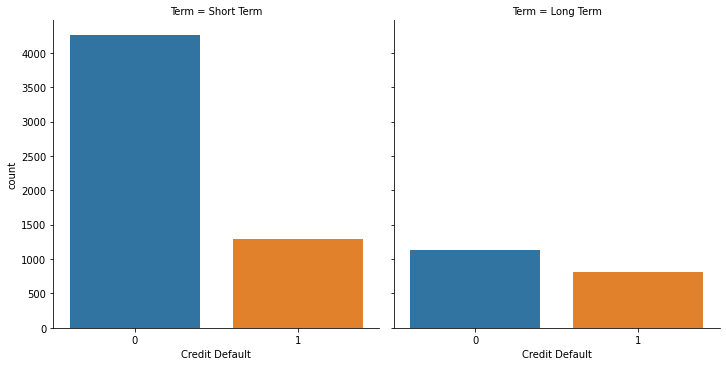

In [8]:
import warnings
warnings.simplefilter('ignore')
for col in cat_feature_names:
    sns.factorplot(x=target_name, col=col, kind='count', data=df_train)

Feature "Home Ownership" likely to have literal: "Have Mortgage" simply is "Home Mortgage"

In [9]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [10]:
print(df_train.loc[df_train.Term == 'Short Term', 'Credit Default'].sum()/df_train.loc[df_train.Term == 'Short Term', 'Credit Default'].count())
print(df_train.loc[df_train.Term == 'Long Term', 'Credit Default'].sum()/df_train.loc[df_train.Term == 'Long Term', 'Credit Default'].count())

0.23344132469402448
0.41975308641975306


No specific conclusion

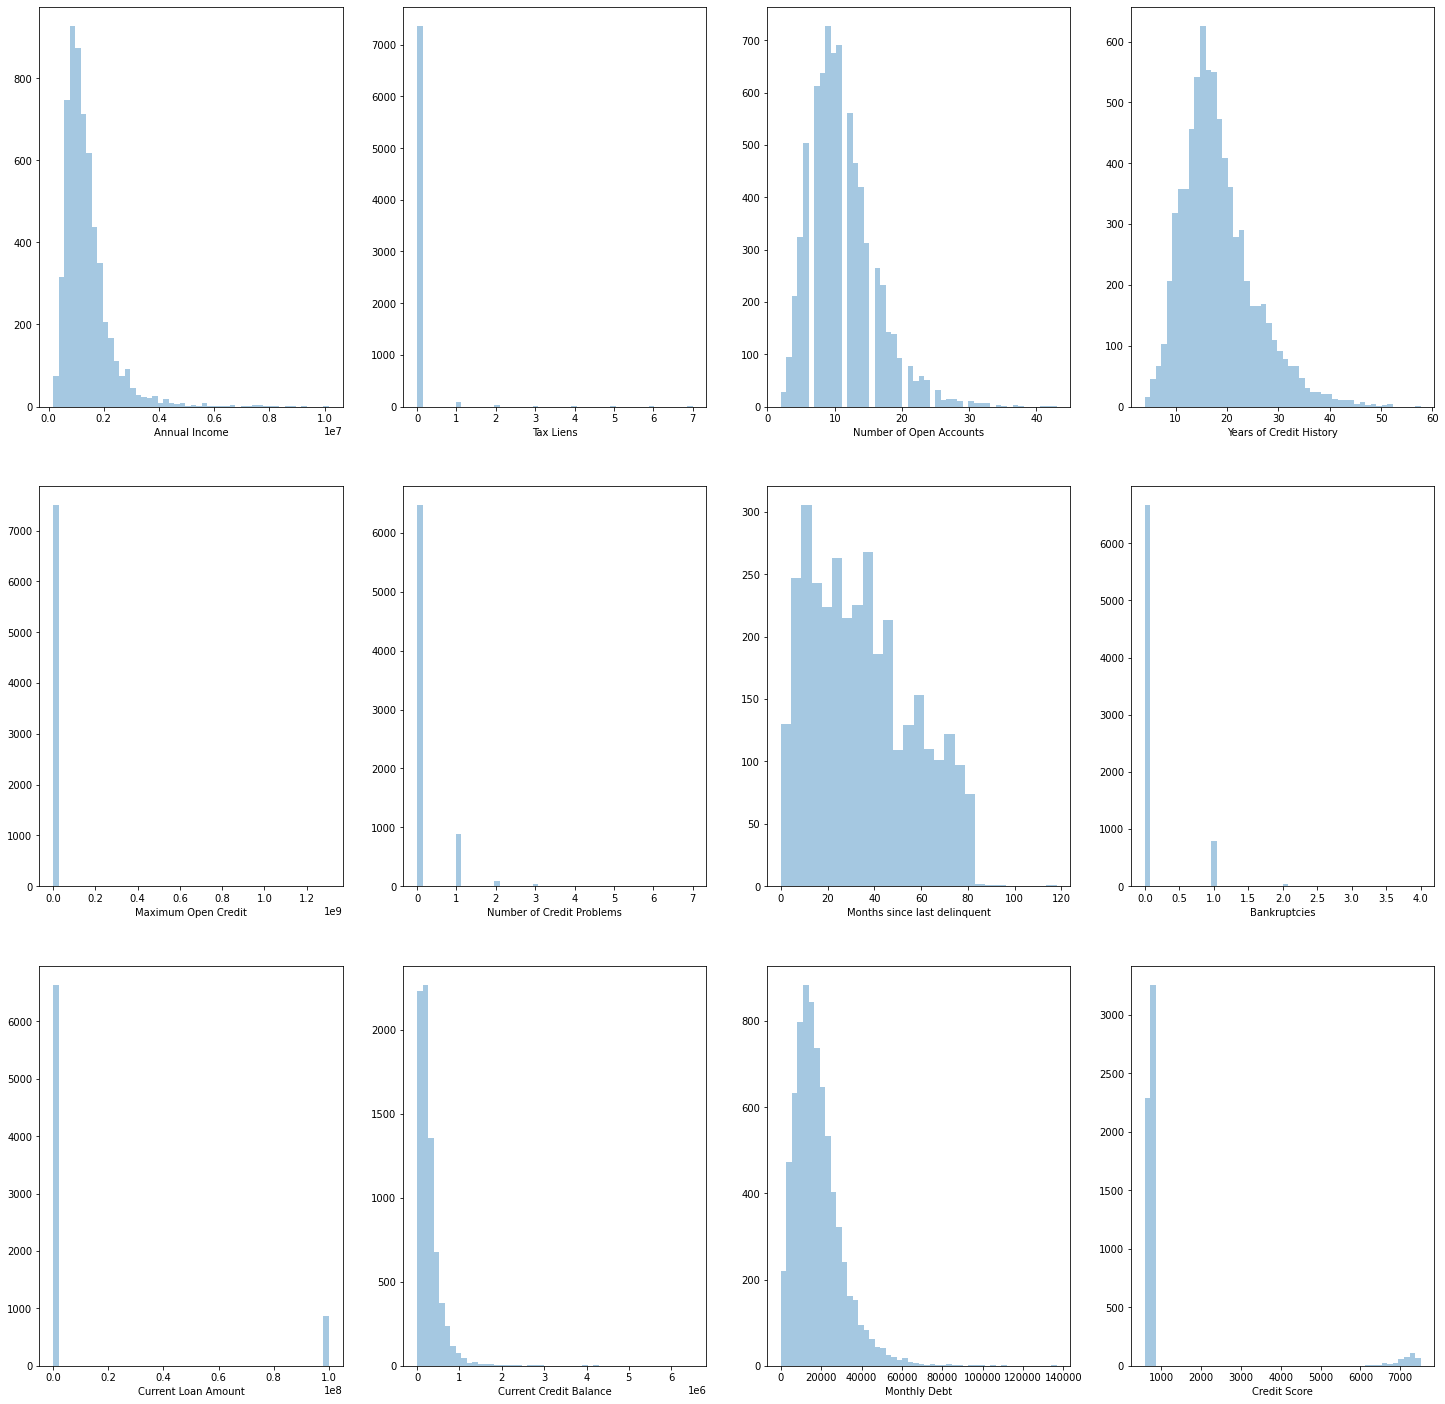

In [11]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(25,25))
for col, ax in zip(num_feature_names, axes.flat):
    sns.distplot(df_train[col], kde=False, ax=ax)
plt.show()

Correlation matrix

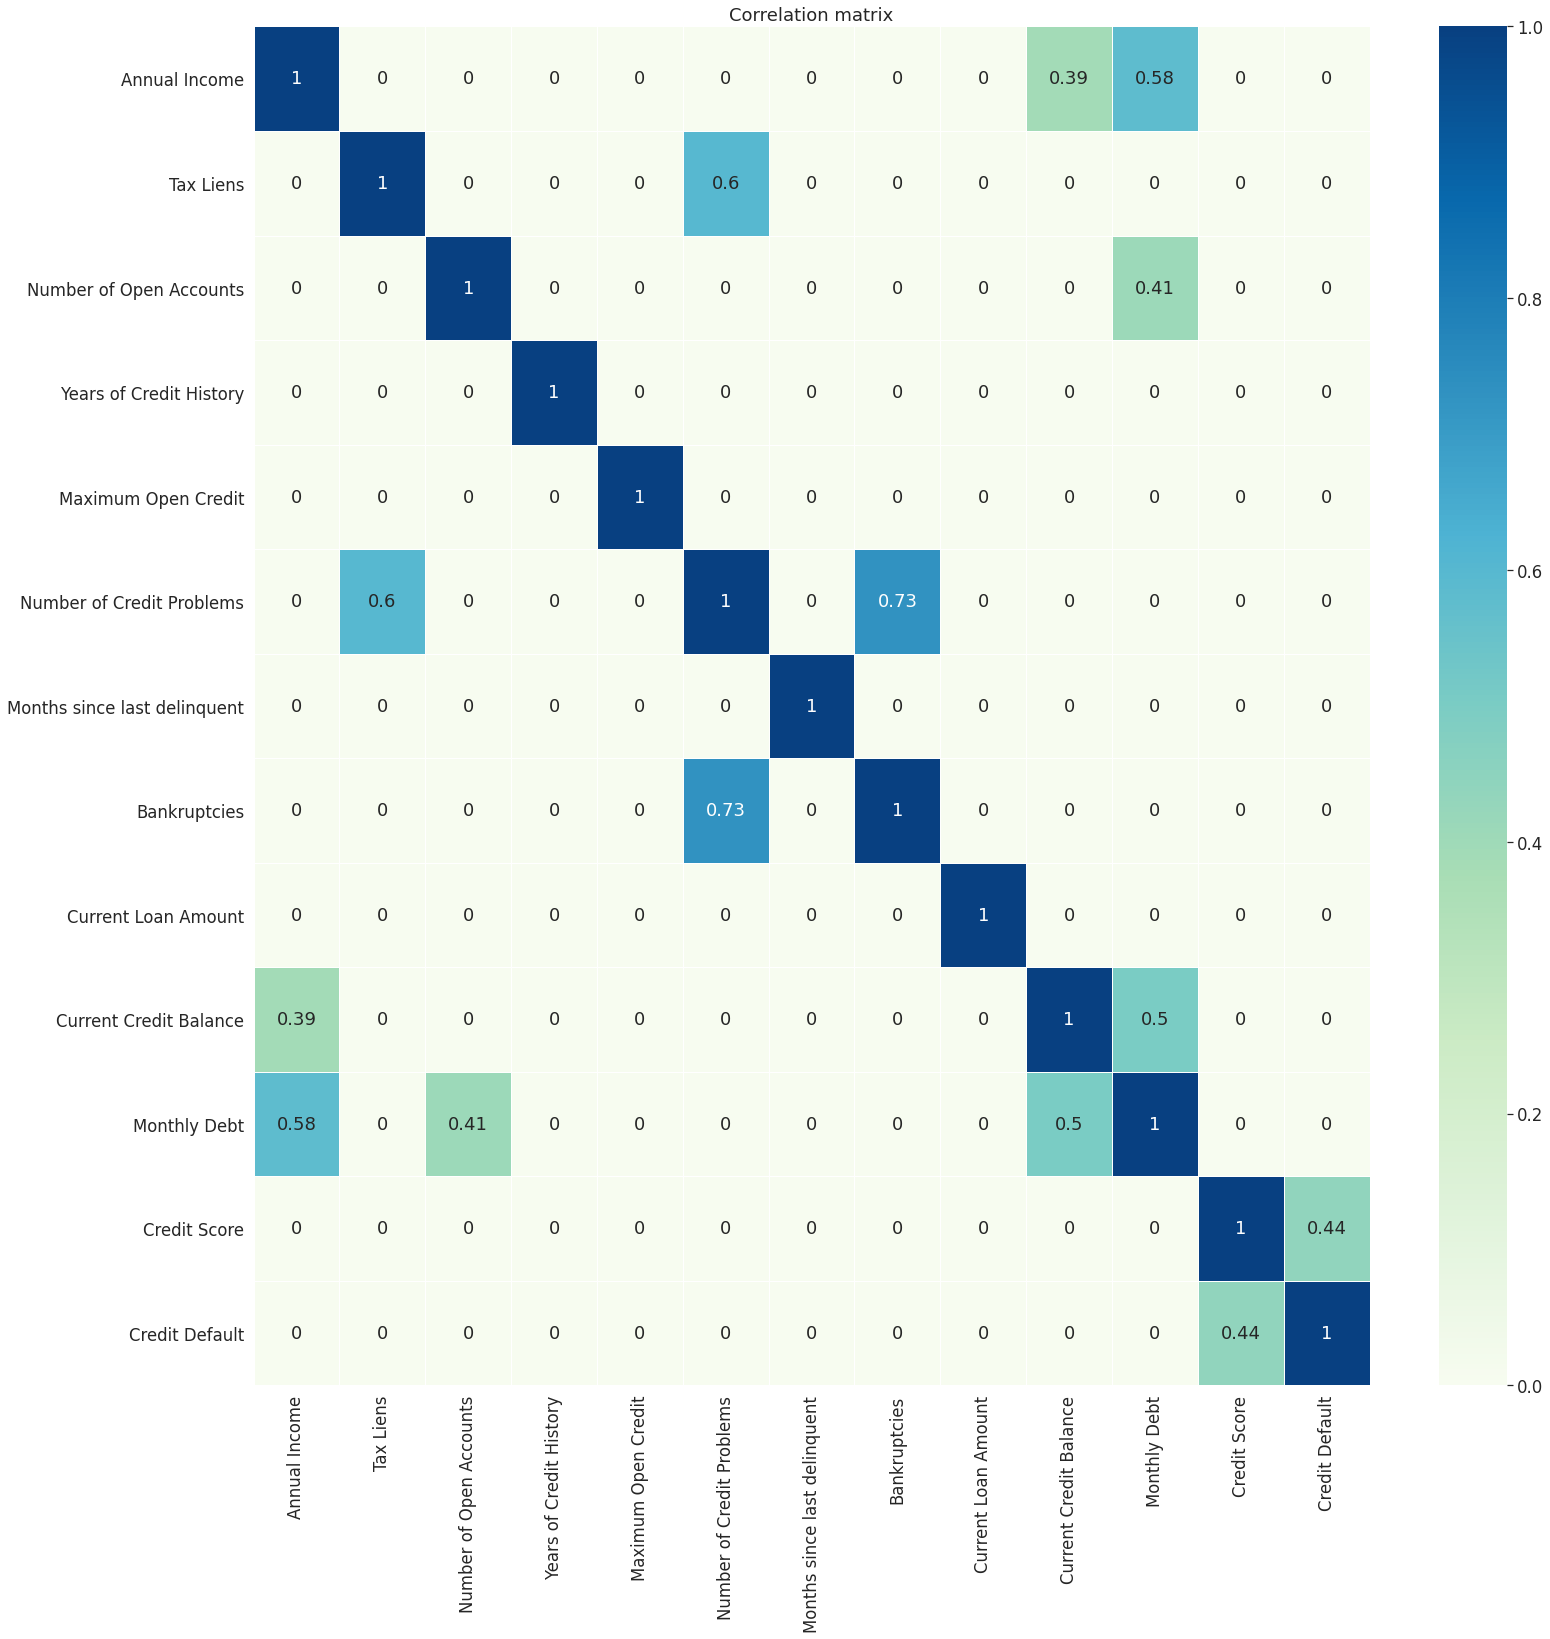

In [12]:
plt.figure(figsize = (25,25))

sns.set(font_scale=1.5)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

No specific conclusion from EDA

**Preprocessing**

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
def spacelessdata(data, target):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target].isna()]
    predict_data = data[data[target].isna()]

    X = train.drop(columns=target)
    y = train[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    baseline = GradientBoostingRegressor(n_estimators=110,
                                  max_depth=8,
                                  random_state=32,
                                  loss='huber',
                                  learning_rate=0.2)
    
    baseline.fit(X_train, y_train)
    
    pred_train = baseline.predict(X_train)
    pred_test = baseline.predict(X_test)
    
    pred = baseline.predict(predict_data.drop(columns=target))
    data.loc[data[target].isna(), target] = list(pred)
    return data

In [14]:
class Preprocessor:
    def __init__(self):
        self.medians = None
        self.years_max_quantille = None
        self.credit_max_quantille = None
        self.loan_quantille = None

    def fit(self, df):
        self.medians = df.median()
        self.years_max_quantille = np.quantile(df['Years of Credit History'], q=0.95)
        self.credit_max_quantille = np.quantile(df['Maximum Open Credit'], q=0.95)
        self.loan_quantille = np.quantile(df['Current Loan Amount'], q=0.9)
                                               
    def transform(self, df):
        
        df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'       
        
        df['Ownership'] = df['Home Ownership'].copy()
        df = pd.get_dummies(df, columns=['Ownership'])
        df.replace({'Home Ownership': {'Own Home': 2, 
                                       'Home Mortgage': 1, 
                                       'Rent': 0}
                    }, inplace=True)
        
        df.replace({'Years in current job': 
                                            {'10+ years': 10,
                                             '9 years': 9, 
                                             '8 years': 8,
                                             '7 years': 7, 
                                             '6 years': 6,
                                             '5 years': 5,
                                             '4 years': 4,
                                             '3 years': 3,
                                             '2 years': 2,
                                             '1 year': 1,
                                             '< 1 year': 0,}}, inplace=True)
        
        self.years_in_cur_job_median = df['Years in current job'].median()
        df['Years in current job'].fillna(self.years_in_cur_job_median, inplace=True)
        
        df.replace({'Purpose': 
                                            {'debt consolidation': 0,
                                             'other': 1, 
                                             'home improvements': 1,
                                             'take a trip': 1, 
                                             'buy a car': 1,
                                             'small business': 2,
                                             'business loan': 2,
                                             'wedding': 1,
                                             'educational expenses': 1,
                                             'buy house': 1,
                                             'medical bills': 1,
                                             'moving': 1,
                                             'major purchase': 1,
                                             'vacation':1,
                                             'renewable energy':1, }}, 
                   inplace=True)
        
        df['Purpose'].fillna(0, inplace=True)
        
        df.replace({'Term': {'Short Term': 0, 
                             'Long Term': 1}}, inplace=True)
        
        df['Months since last delinquent'].fillna(0, inplace=True)
        
        df['Annual Income'].fillna(1, inplace = True)
        
        df['Credit Score'].fillna(1, inplace=True)
        df['Credit Score Outlier'] = 0
        df.loc[df['Credit Score'] > 1000, 'Credit Score Outlier'] = 1
        df.loc[df['Credit Score'] > 1000, 'Credit Score'] = df.loc[df['Credit Score'] > 1000, 'Credit Score'] / 10
        
        df['Bankruptcies'].fillna(0, inplace=True)
        
        df['Years of Credit History'].clip(lower=None, upper=self.years_max_quantille, inplace=True)
        
        df.loc[df['Annual Income'] == 1, 'Annual Income'] = np.nan
        df = spacelessdata(df, 'Annual Income')
        
        df.loc[df['Credit Score'] == 1, ['Credit Score']] = np.nan
        df = spacelessdata(df, 'Credit Score')
        
        df.loc[df['Current Loan Amount'] >= self.loan_quantille, ['Current Loan Amount']] = np.nan
        df = spacelessdata(df, 'Current Loan Amount')
        
        df.loc[df['Maximum Open Credit'] > self.credit_max_quantille, ['Maximum Open Credit']] = np.nan
        df = spacelessdata(df, 'Maximum Open Credit')
        
        return df

In [15]:
class FeatureGenerator:
    def __init__(self):
        self.median = None
        self.ownership_rating = None
        self.job_years_rating = None
        self.credit_default_score_mode = None
        self.median_loan_by_purpose = None

    def fit(self, df):
        self.medians = df.median()
        self.ownership_rating = df.groupby(['Home Ownership'])['Credit Score'].agg('median').to_dict()
        self.job_years_rating = df.groupby(['Years in current job'])['Credit Score'].agg('median').to_dict()
        self.credit_default_score_mode = df.groupby(['Credit Default'])['Credit Score'].agg(pd.Series.mode)[1]
        self.median_loan_by_purpose = df.groupby(['Purpose'])['Current Loan Amount'].agg('median').to_dict()

    def transform(self, df):
        df['Credit to income ratio'] = np.round((df['Annual Income']/12) / df['Monthly Debt'], 3)
        df.loc[df['Credit to income ratio'] == np.inf, ['Credit to income ratio']] = df['Credit to income ratio'].median()
        
        df['Loan to income ratio'] = np.round((df['Annual Income']/12) / df['Current Loan Amount'], 3)
        df.loc[df['Loan to income ratio'] == np.inf, ['Loan to income ratio']] = df['Loan to income ratio'].median()

        df['Ownership_credit_rating'] = df['Home Ownership'].map(self.ownership_rating)

        df['Years in job rating'] = df['Years in current job'].map(self.job_years_rating)

        df['Credit Default Score Delta'] = abs(df['Credit Score'] - self.credit_default_score_mode)

        df['Loan_by_term'] = df['Purpose'].map(self.median_loan_by_purpose)

        return df

**Predicting**

In [16]:
preprocessor = Preprocessor()
preprocessor.fit(df_train)
df_train = preprocessor.transform(df_train)
df_test = preprocessor.transform(df_test)


feature_gen = FeatureGenerator()
feature_gen.fit(df_train)
df_train = feature_gen.transform(df_train)
df_test = feature_gen.transform(df_test)

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   int64  
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   int64  
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   int64  
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   float64
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   int64  
 11  Term                          2500 non-null   int64  
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [19]:
X = pd.DataFrame(data=df_train.drop('Credit Default', axis=1))
y = pd.DataFrame(data=df_train['Credit Default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100, stratify=y)

**Evaluating**

In [20]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))


def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [21]:
disbalance = int(y_train.value_counts()[0]) / int(y_train.value_counts()[1])
disbalance

2.548895899053628

In [22]:
from catboost import CatBoostClassifier
model_catb = CatBoostClassifier(silent=True, random_state=21,
                                    class_weights=[1, disbalance],
                                    allow_writing_files=False,
                                    learning_rate=0.2,
                                    max_depth=3,
                                    n_estimators=95,
                                    eval_metric='F1',
                                    reg_lambda=2.617721518987342,
                                    early_stopping_rounds=30,
                                    use_best_model=True,
                                    custom_metric=['Precision', 'Recall'],
                                    subsample=0.8,)
                                     
model_catb.fit(X_train, y_train, eval_set=(X_test, y_test))

In [23]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.73      0.79      4040
           1       0.50      0.68      0.58      1585

    accuracy                           0.72      5625
   macro avg       0.68      0.71      0.68      5625
weighted avg       0.76      0.72      0.73      5625

TEST

              precision    recall  f1-score   support

           0       0.84      0.71      0.77      1347
           1       0.46      0.65      0.54       528

    accuracy                           0.69      1875
   macro avg       0.65      0.68      0.65      1875
weighted avg       0.73      0.69      0.70      1875



In [24]:
predictions = model_catb.predict(df_test)
predictions = predictions.astype('int32')

In [25]:
predictions

array([0, 1, 1, ..., 1, 0, 1], dtype=int32)

In [26]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1


In [27]:
submit.to_csv('csv_to_submit.csv', index=False)